In [28]:
#forecasting Croston y_test
import numpy as np
import random
from croston import croston
# Import pandas dataset
import pandas as pd
import matplotlib.pyplot as plt
# Style of plots
plt.style.use('fivethirtyeight')

In [29]:
#import and create date
df= pd.read_csv('datos_de_prueba.csv', sep=';',decimal=',')
data = pd.DataFrame(df, columns= ['Fecha','Venta'])
data['Fecha']= pd.to_datetime(df['Fecha']) 
data.set_index('Fecha', inplace=True)
data = data.rename_axis(index=None, columns=None)
data =  (data[data.index <= '31-08-2019 '])
#divide train and test set
y_train = (data[data.index < '2019-07-01 '])
y_test = (data[data.index >= '2019-07-01 '  ])
demand= pd.read_csv('Fits_Test_Eduards_demand_dss.csv', sep=';',decimal='.')

In [30]:
df1=pd.DataFrame({"Date" : y_train.index, "Count" : y_train.Venta})
df1.reset_index(inplace=True)
df1=df1.drop('index', 1)

In [31]:
df1.transpose()

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
Date,2017-08-01 00:00:00,2017-08-02 00:00:00,2017-08-03 00:00:00,2017-08-04 00:00:00,2017-08-05 00:00:00,2017-08-07 00:00:00,2017-08-08 00:00:00,2017-08-09 00:00:00,2017-08-10 00:00:00,2017-08-11 00:00:00,...,2019-06-18 00:00:00,2019-06-19 00:00:00,2019-06-20 00:00:00,2019-06-21 00:00:00,2019-06-22 00:00:00,2019-06-24 00:00:00,2019-06-25 00:00:00,2019-06-26 00:00:00,2019-06-27 00:00:00,2019-06-28 00:00:00
Count,1,0,3,1,2,1,1,2,0,1,...,3,0,2,1,1,0,2,2,1,0


In [32]:
#  q is often called the “demand” and a the “inter-arrival time”.
q = df1[abs(df1['Count']) > 0.0]['Count']
demand_times = pd.Series(list(q.index)) + 1
a = demand_times - demand_times.shift(1).fillna(0.0)
df2 = pd.DataFrame({'demand_time' : list(demand_times), 'q' : list(q) , 'a' : list(a) })

In [33]:
def get_coeff(alpha , croston_type):
    if(croston_type == "sba"):
        return 1.0-(alpha/2.0)
    elif(croston_type == "sbj"):
        return (1.0 - alpha/(2.0-alpha))
    # default 
    return 1.0

In [34]:
# q  and a forecast
alpha = 0.1

df2['q_est'] = None
df2['a_est'] = None

df2.loc[0 , 'q_est'] = df2['q'][0]
df2.loc[0,  'a_est'] = df2['a'][0]
for i in range(df2.shape[0] - 1):
    q1 = (1.0 - alpha) * df2['q_est'][ i ] + alpha * df2['q'][ i ]
    a1 = (1.0 - alpha) * df2['a_est'][ i ] + alpha * df2['a'][ i ]
    df2.loc[i + 1, 'q_est'] = q1
    df2.loc[i + 1, 'a_est'] = a1

In [35]:
coeff = get_coeff(alpha , "default")
df2['forecast'] = coeff * df2['q_est'] / df2['a_est']
df2

,demand_time,q,a,q_est,a_est,forecast
0,1,1.0,1.0,1,1,1
1,3,3.0,2.0,1,1,1
2,4,1.0,1.0,1.2,1.1,1.09091
3,5,2.0,1.0,1.18,1.09,1.08257
4,6,1.0,1.0,1.262,1.081,1.16744
...,...,...,...,...,...,...
427,563,1.0,1.0,1.98816,1.81735,1.09399
428,564,1.0,1.0,1.88935,1.73562,1.08857
429,566,2.0,2.0,1.80041,1.66206,1.08324
430,567,2.0,1.0,1.82037,1.69585,1.07343


In [36]:
forecast_11 = df2['q_est'][10] / df2['a_est'][10]
df2['index'] = df2['demand_time'] - 1
df1 = df1.reset_index()
df3 = df1.merge(df2 , how='left', on=('index' , 'index'))
df3

,index,Date,Count,demand_time,q,a,q_est,a_est,forecast
0,0,2017-08-01,1.0,1.0,1.0,1.0,1,1,1
1,1,2017-08-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2017-08-03,3.0,3.0,3.0,2.0,1,1,1
3,3,2017-08-04,1.0,4.0,1.0,1.0,1.2,1.1,1.09091
4,4,2017-08-05,2.0,5.0,2.0,1.0,1.18,1.09,1.08257
...,...,...,...,...,...,...,...,...,...
564,564,2019-06-24,0.0,NaN,NaN,NaN,NaN,NaN,NaN
565,565,2019-06-25,2.0,566.0,2.0,2.0,1.80041,1.66206,1.08324
566,566,2019-06-26,2.0,567.0,2.0,1.0,1.82037,1.69585,1.07343
567,567,2019-06-27,1.0,568.0,1.0,1.0,1.83833,1.62627,1.1304


In [37]:
df2['index'] = df2['demand_time'] - 1
df1 = df1.reset_index()
df3 = df1.merge(df2 , how='left', on=('index' , 'index'))
df3

,level_0,index,Date,Count,demand_time,q,a,q_est,a_est,forecast
0,0,0,2017-08-01,1.0,1.0,1.0,1.0,1,1,1
1,1,1,2017-08-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2017-08-03,3.0,3.0,3.0,2.0,1,1,1
3,3,3,2017-08-04,1.0,4.0,1.0,1.0,1.2,1.1,1.09091
4,4,4,2017-08-05,2.0,5.0,2.0,1.0,1.18,1.09,1.08257
...,...,...,...,...,...,...,...,...,...,...
564,564,564,2019-06-24,0.0,NaN,NaN,NaN,NaN,NaN,NaN
565,565,565,2019-06-25,2.0,566.0,2.0,2.0,1.80041,1.66206,1.08324
566,566,566,2019-06-26,2.0,567.0,2.0,1.0,1.82037,1.69585,1.07343
567,567,567,2019-06-27,1.0,568.0,1.0,1.0,1.83833,1.62627,1.1304


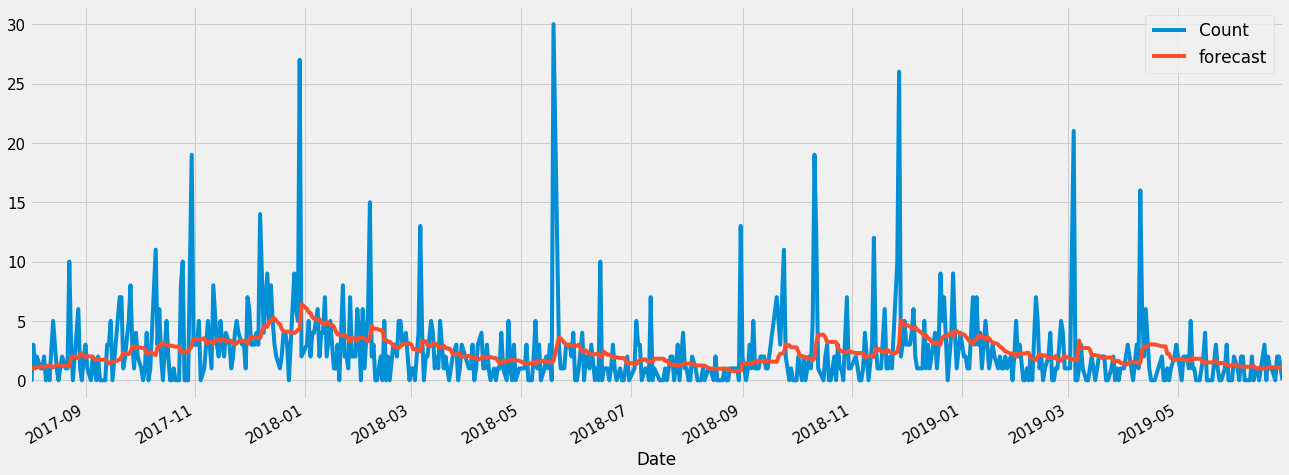

In [40]:
df4 = df3.fillna(method='ffill')
df4.plot('Date', ['Count' , 'forecast'])

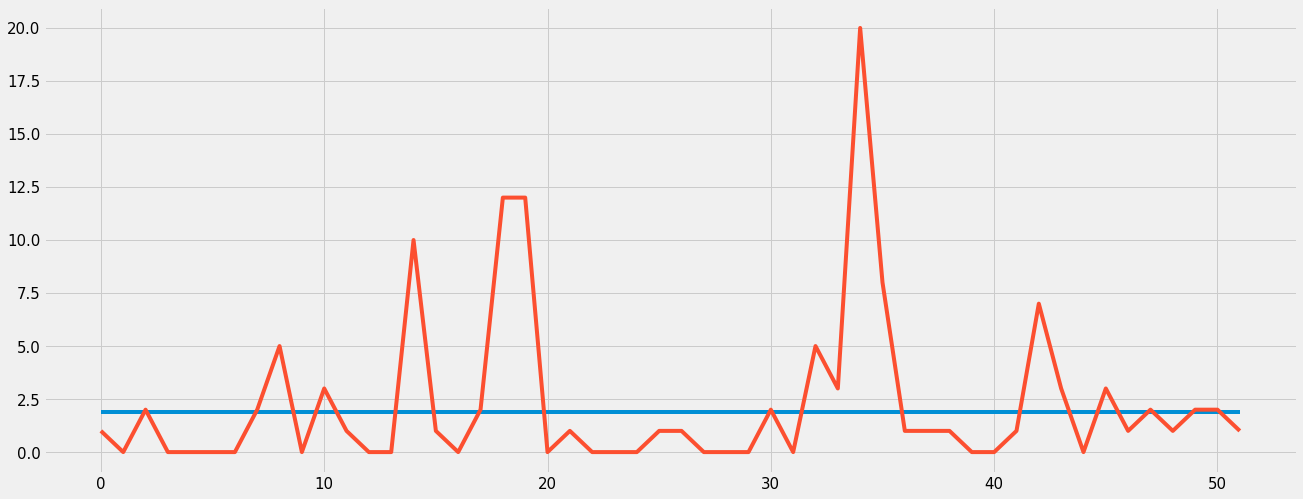

In [41]:
fit_pred = croston.fit_croston(y_train, len(y_test),'original')
fit_pred1 = croston.fit_croston(y_train, len(y_test), 'sba') # Syntetos-Boylan approximation
fit_pred2 = croston.fit_croston(y_train, len(y_test), 'sbj') # Shale-Boylan-Johnston
plt.plot(fit_pred2['croston_forecast'])
plt.plot(y_test.values)
size=20
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

In [26]:
croston_fit = pd.DataFrame(fit_pred2['croston_forecast'], columns= ['croston_forecast'])
croston_fit.to_csv('croston_fit.csv')